In [2]:
import numpy as np
import scipy
import pandas as pd
import pybedtools as pb

# figs
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rcParams['figure.dpi']= 150
import seaborn as sns


#import h5py
#import allel

# my libs
import EnrichRLib as erl
import RNA_expression_processing as rn
import Enh_Mut_Manip as emm

# warnings
import warnings
warnings.filterwarnings('ignore')
#warnings.simplefilter("ignore", ResourceWarning)

In [3]:
### == Math functions == 
def log2p1(x):
    return np.log2(x + 1)

In [4]:
# Project settings
from os.path import join 
WORKDIR = '/home/sergio/Res_CIML/TLX3_project'
SCRIPTS = join(WORKDIR,'scripts')
DATADIR = join(WORKDIR,'data')
WGS = join(DATADIR,'tracks/WGS-WES/Germline')
RP = join(DATADIR,'tracks/MARGE/relativeRP/bam_input')

# Data loading

### Genome Wide mutations in TLX3

In [5]:
## == Genome vcf
tlx_gn = pb.BedTool(join(WGS,'TLX3_WGS.vcf.gz'))

### RNA-expression table TLX3-vs-RAG

In [6]:
## == Expression table TLX3 vs RAG
tbl = pd.read_table(join(DATADIR,'tracks', 'TLX3vsRAG-results_genesNames.txt'), index_col=0)
#tbl = tbl[(tbl.padj < 0.05)].dropna()

# -- Pheno --
#A,B = 'TLX3','RAG'
#classes = [A]*3+[B]*3


cols = ['Gene_name', 'TLX3.1_1','TLX3.1_5','TLX3.1_P','R2.RAG1W.RAG1','RAGS.RAGZ','RAGZ']

tbn = tbl[cols]
expr = tbn.set_index(keys=tbn.columns[0])
#expr.index = expr.index.str.upper()

### Enhancers from chromatin states

In [7]:
## == Enhancers 
enh = pb.BedTool(join(DATADIR,'tracks/Enhancers_ChromHMM.bed'))
enh_df = enh.to_dataframe()

# Enh to genes table
enh2gn = pd.read_table(join(DATADIR,'tracks/Enhancers_ChromHMM_enh2genes.txt'), 
                        header=1, 
                        names=['enhancers','gene_name'])
# Gene to enh table
gn2enh = pd.read_table(join(DATADIR,'tracks/Enhancers_ChromHMM_genes2enh.txt'), 
                        header=1, 
                        names=['gene_name','enhancers'])


### Regulatory potentials based on H3K27ac -- TLX3-vs-RAG

In [8]:
# Regulatory Potentials
rpt  =  pd.read_table(join(RP,'RAG_TLX_TAP_relativeRP_mm10mm9.txt'))

# -- transform
rp = rpt.sort_values('lgFC_TLXvsRAG', axis=0, ascending=False)
rp.drop_duplicates(subset='gene_name', inplace=True)


Ap,Bp = 'TLX_rel_RP','RAG_rel_RP'
cols = ['gene_name', Ap, Bp]

rp = rp[cols]
rp = rp.set_index(keys=rp.columns[0])


### Annotations: genes, tss, T-all oncogenes etc.

In [9]:
# Load T-ALL ocnogenes
tall = erl.read_gmt(join(DATADIR,'gene_lists/Cancermine/T-ALL.gmt')) 
df_mut = pd.read_csv(join(DATADIR,'gene_lists/COSMIC/Genes_mutation_HUMAN_Acute-lymphoblastic-leukaemia.csv'))

df_mut['Gname'] = df_mut['Gene name'].apply(lambda x: x.split('_')[0])

tall_onc = tall['T-ALL all']
tall_mut = list(df_mut['Gname'].unique())

# Load genes body regions
genes = pb.BedTool(join(DATADIR,'tracks/annot_tracks/references/mm9/mm9.refGene.bed'))


# Story ONE: Active in TLX3 only enhancers and active genes 

![title](im/Story1.png)

## Active enhacers in TLX3 not in RAG based on H4K27ac potential

In [10]:
pad = 3e3 # 3k padding 

#tlx_27ac = join(DATADIR,'tracks/ChiP-seq_tracks/mm9_bigWig/TAP_H3K27ac_mm9.bw')
#rag_27ac = join(DATADIR,'tracks/ChiP-seq_tracks/mm9_bigWig/RAG_H3K27ac_mm9.bw')


#enh_27ac_tlx = emm.bigWig2bed_pot(tlx_27ac,enh,'mm9',pad=pad)

tlx_27ac = pd.read_csv(join(DATADIR,'tracks/Enhancers_ChromHMM_TLX3_H3K27ac.csv'), index_col=0)
rag_27ac = pd.read_csv(join(DATADIR,'tracks/Enhancers_ChromHMM_RAG_H3K27ac.csv'), index_col=0)

tlx_27ac.rename(columns={'RP':'RP_tlx'}, inplace=True)

rag_27ac.rename(columns={'RP':'RP_rag'}, inplace=True)

tlx_rag_27ac = pd.concat([tlx_27ac,rag_27ac.drop(['chrom','start','end', 'name'], axis=1)], axis=1)

In [11]:
# PolII in TLX3 signal on enhancers for verification
tlx_polII = pd.read_csv(join(DATADIR,'tracks/Enhancers_ChromHMM_TLX3_PolII.csv'), index_col=0)

tlx_polII.rename(columns={'RP':'RP_tlx_polII'}, inplace=True)
tlx_rag_27ac = pd.concat([tlx_27ac,rag_27ac.drop(['chrom','start','end', 'name'], axis=1)], axis=1)

tlx_rag_27ac_polII = pd.concat([tlx_27ac,
                                rag_27ac.drop(['chrom','start','end', 'name'], axis=1),
                                tlx_polII.drop(['chrom','start','end', 'name'], axis=1)], axis=1)

## Scatter plot of enhacer's activity TLX3-vs-RAG: color is PolII signal strength

(5.484464325834437, 14.766214510327096, 6.874249067576207, 14.182394229726976)

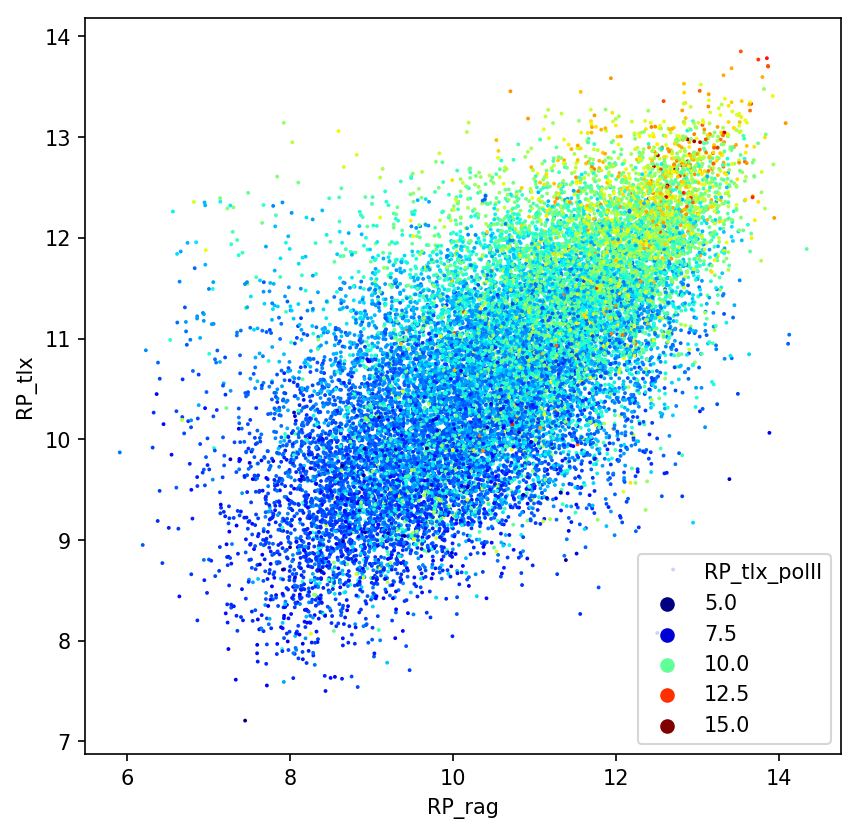

In [12]:
dpc = tlx_rag_27ac_polII.copy()#head(8000)

f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.scatterplot(x = log2p1(dpc['RP_rag']), 
                    y = log2p1(dpc['RP_tlx']), 
                    hue=log2p1(dpc['RP_tlx_polII']), 
                    data=dpc, 
                    ax=ax, 
                    palette='jet',#'gnuplot',#'jet',#'RdBu_r', 
                    linewidth=0, 
                    s=3.4)

ax.axis('equal')
ax.axis('tight')

## Scatter plot of enhacer's activity TLX3-vs-RAG: color logFoldChange

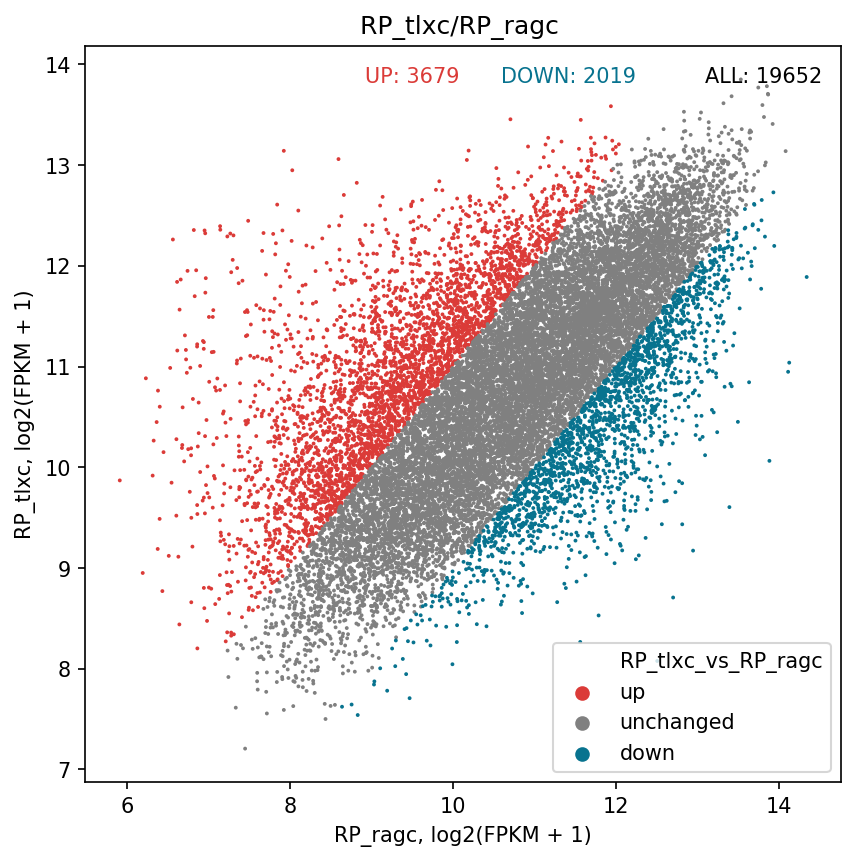

In [13]:
## Scatter of 27ac potential on enhancers

Ap,Bp = 'RP_tlx','RP_rag'
cols = ['name', Ap, Bp]

tlx_rag_27ac_s = tlx_rag_27ac[cols]

tlx_rag_27ac_s = tlx_rag_27ac_s.set_index(keys=tlx_rag_27ac_s.columns[0])

tlx_rag_27ac_s = tlx_rag_27ac_s.apply(pd.to_numeric)

Ac= Ap+'c'
Bc= Bp+'c'

classes=[Ac,Bc]
#df_mean= tlx_rag_27ac_s.groupby(by=classes, axis=1).mean()

df=rn.scatter_n(tlx_rag_27ac_s, Ac, Bc,classes=classes)

In [14]:
## UP regulated by H3K27ac enhancers
tlx_rag_27ac_FC=df[0]


### genes associate with top UP enhancers
tlx_vs_rag_top = list(tlx_rag_27ac_FC.index)
tlx_vs_rag_topGenes = emm.gene_enh(tlx_vs_rag_top,enh2gn)


## UP/DOWN genes regulated by activated in TLX3 enhacers  

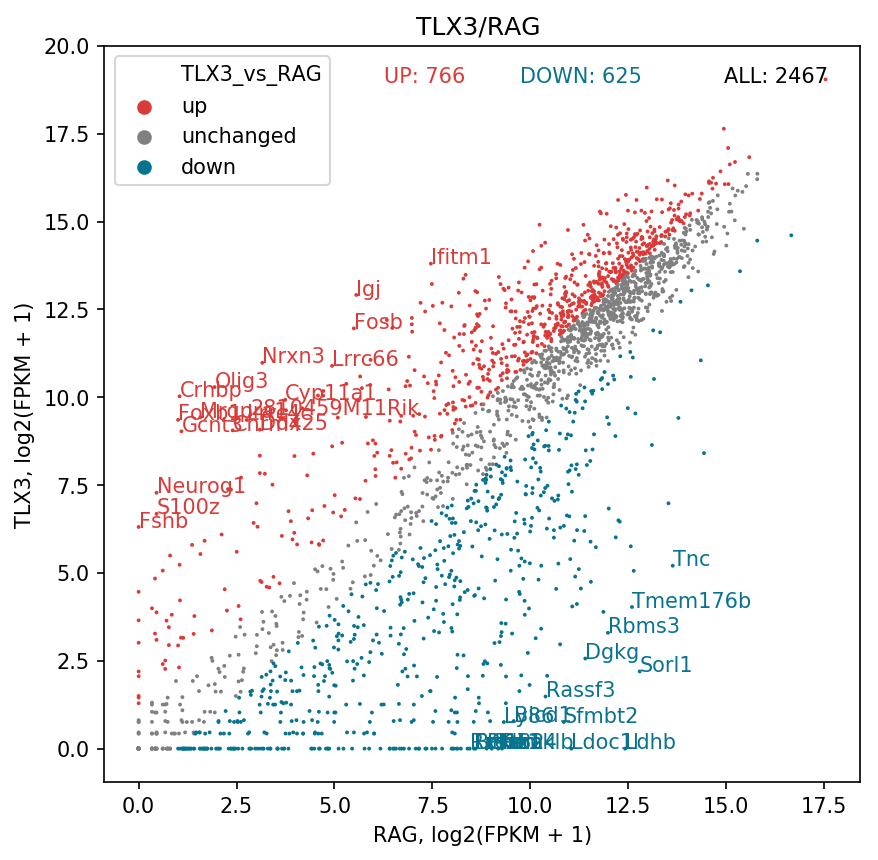

In [15]:
# -- Pheno --
A,B = 'TLX3','RAG'
classes = [A]*3+[B]*3

tmp=rn.scatter_n(expr[expr.index.isin(tlx_vs_rag_topGenes)], A, B,classes=classes, n_top=18)

In [16]:
## enhancers from UP genes
up_genes = list(tmp[0].index)
up_gene_enh =  emm.enh_gene(up_genes,gn2enh)

In [17]:
print('Up regulated enhancers = ',len(tlx_vs_rag_top))
print('Enhancers of up-regulated genes  = ',len(up_gene_enh))

Up regulated enhancers =  3679
Enhancers of up-regulated genes  =  5575


In [18]:
# Up enhancers with up genes
up_enh_up_genes = list(set(tlx_vs_rag_top) & set(up_gene_enh))
print('Up enhancers of up-regulated genes  = ',len(up_enh_up_genes))

Up enhancers of up-regulated genes  =  2183


In [19]:
# Load TLX3 peaks
tlx_pk = pb.BedTool(join(DATADIR,'tracks/TLX3_TLX3_peaks.bed'))
sl = 100
tlx_pk = tlx_pk.slop(b=sl, genome='mm9')

enh_up_up= enh_df[enh_df['name'].isin(up_enh_up_genes)]
enh_up_up_bd = pb.BedTool.from_dataframe(enh_up_up)

enh_up_up_tlx = (enh_up_up_bd + tlx_pk).to_dataframe()

In [20]:
# Finally
# associated genes
enh_up_up_tlx_genes = emm.gene_enh(list(enh_up_up_tlx['name']),enh2gn)

print('Genes for UP regulated (H3K27ac) enhancers with TLX3 peaks  with UP regulated genes = ',len(enh_up_up_tlx_genes))
print('UP regulated (H3K27ac) enhancers with TLX3 peaks  with UP regulated genes = ',len(enh_up_up_tlx))

Genes for UP regulated (H3K27ac) enhancers with TLX3 peaks  with UP regulated genes =  830
UP regulated (H3K27ac) enhancers with TLX3 peaks  with UP regulated genes =  749


## UP regulated final genes

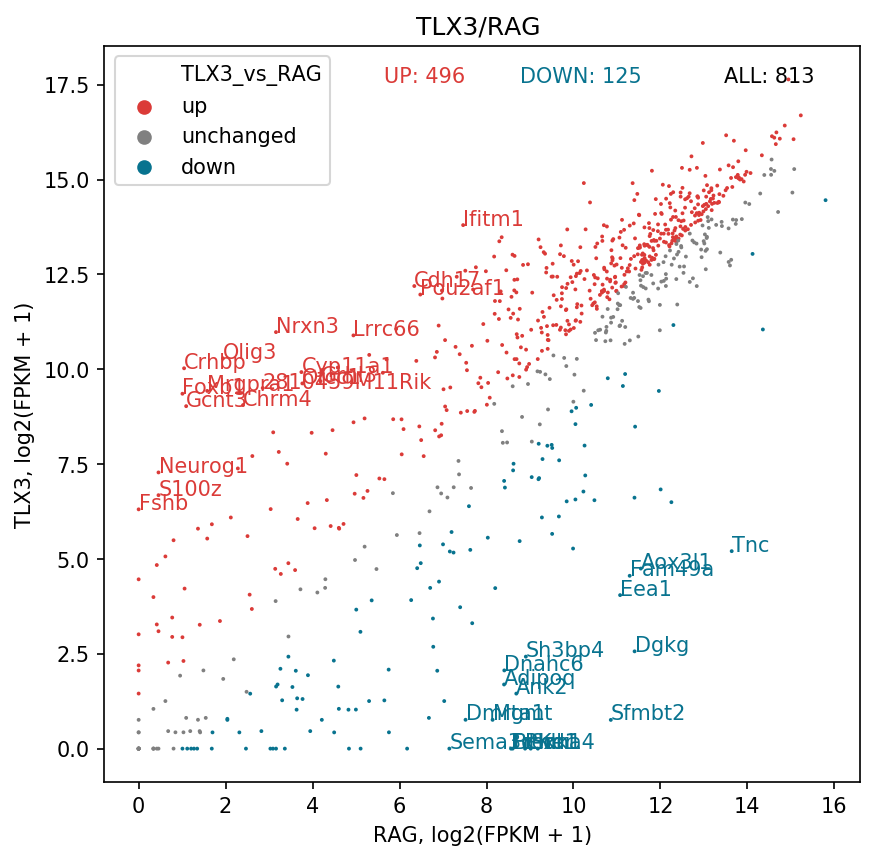

In [21]:
## Expression of last genes

# -- Pheno --
A,B = 'TLX3','RAG'
classes = [A]*3+[B]*3

tmp=rn.scatter_n(expr[expr.index.isin(enh_up_up_tlx_genes)], A, B,classes=classes, n_top=18)

## Enrichment of final 496 genes

In [22]:
fin_up_genes = list(tmp[0].index)

## Enrichment analysis
# List of gene sets 
gss = [ 
       'GO_Biological_Process_2018',
       'GO_Cellular_Component_2018',
       'GO_Molecular_Function_2018',
       'KEGG_2016',
       'Reactome_2016',
       'Cancer_Cell_Line_Encyclopedia',
       'NCI-60_Cancer_Cell_Lines',
       ]

FIN_up_genes = [x.upper() for x in fin_up_genes]

enr = erl.enrich_gs(FIN_up_genes,gss, path_lib='../data/EnrichrLibs')

GO_Biological_Process_2018 2534
GO_Cellular_Component_2018 219
GO_Molecular_Function_2018 523
KEGG_2016 228
Reactome_2016 903
Cancer_Cell_Line_Encyclopedia 825
NCI-60_Cancer_Cell_Lines 93


In [23]:
# For futher analysis it is convinient to filter terms by p-value
enr_a = enr[enr['p-Val']<0.001]


In [24]:
## Cluster: this calculate and add cluster number column
enr_a = erl.cluster(FIN_up_genes,enr_a)

# Make additional calculation on existing columns for visualization
enr_a.loc[:,'ass_genes_percnt'] = 100*enr_a.loc[:,'num_list']/enr_a.loc[:,'num_term']
enr_a.sort_values('cluster', axis=0, inplace = True)


Text(0.5,1,'UP genes regulated by UP enhancers with high Tlx3 peaks')

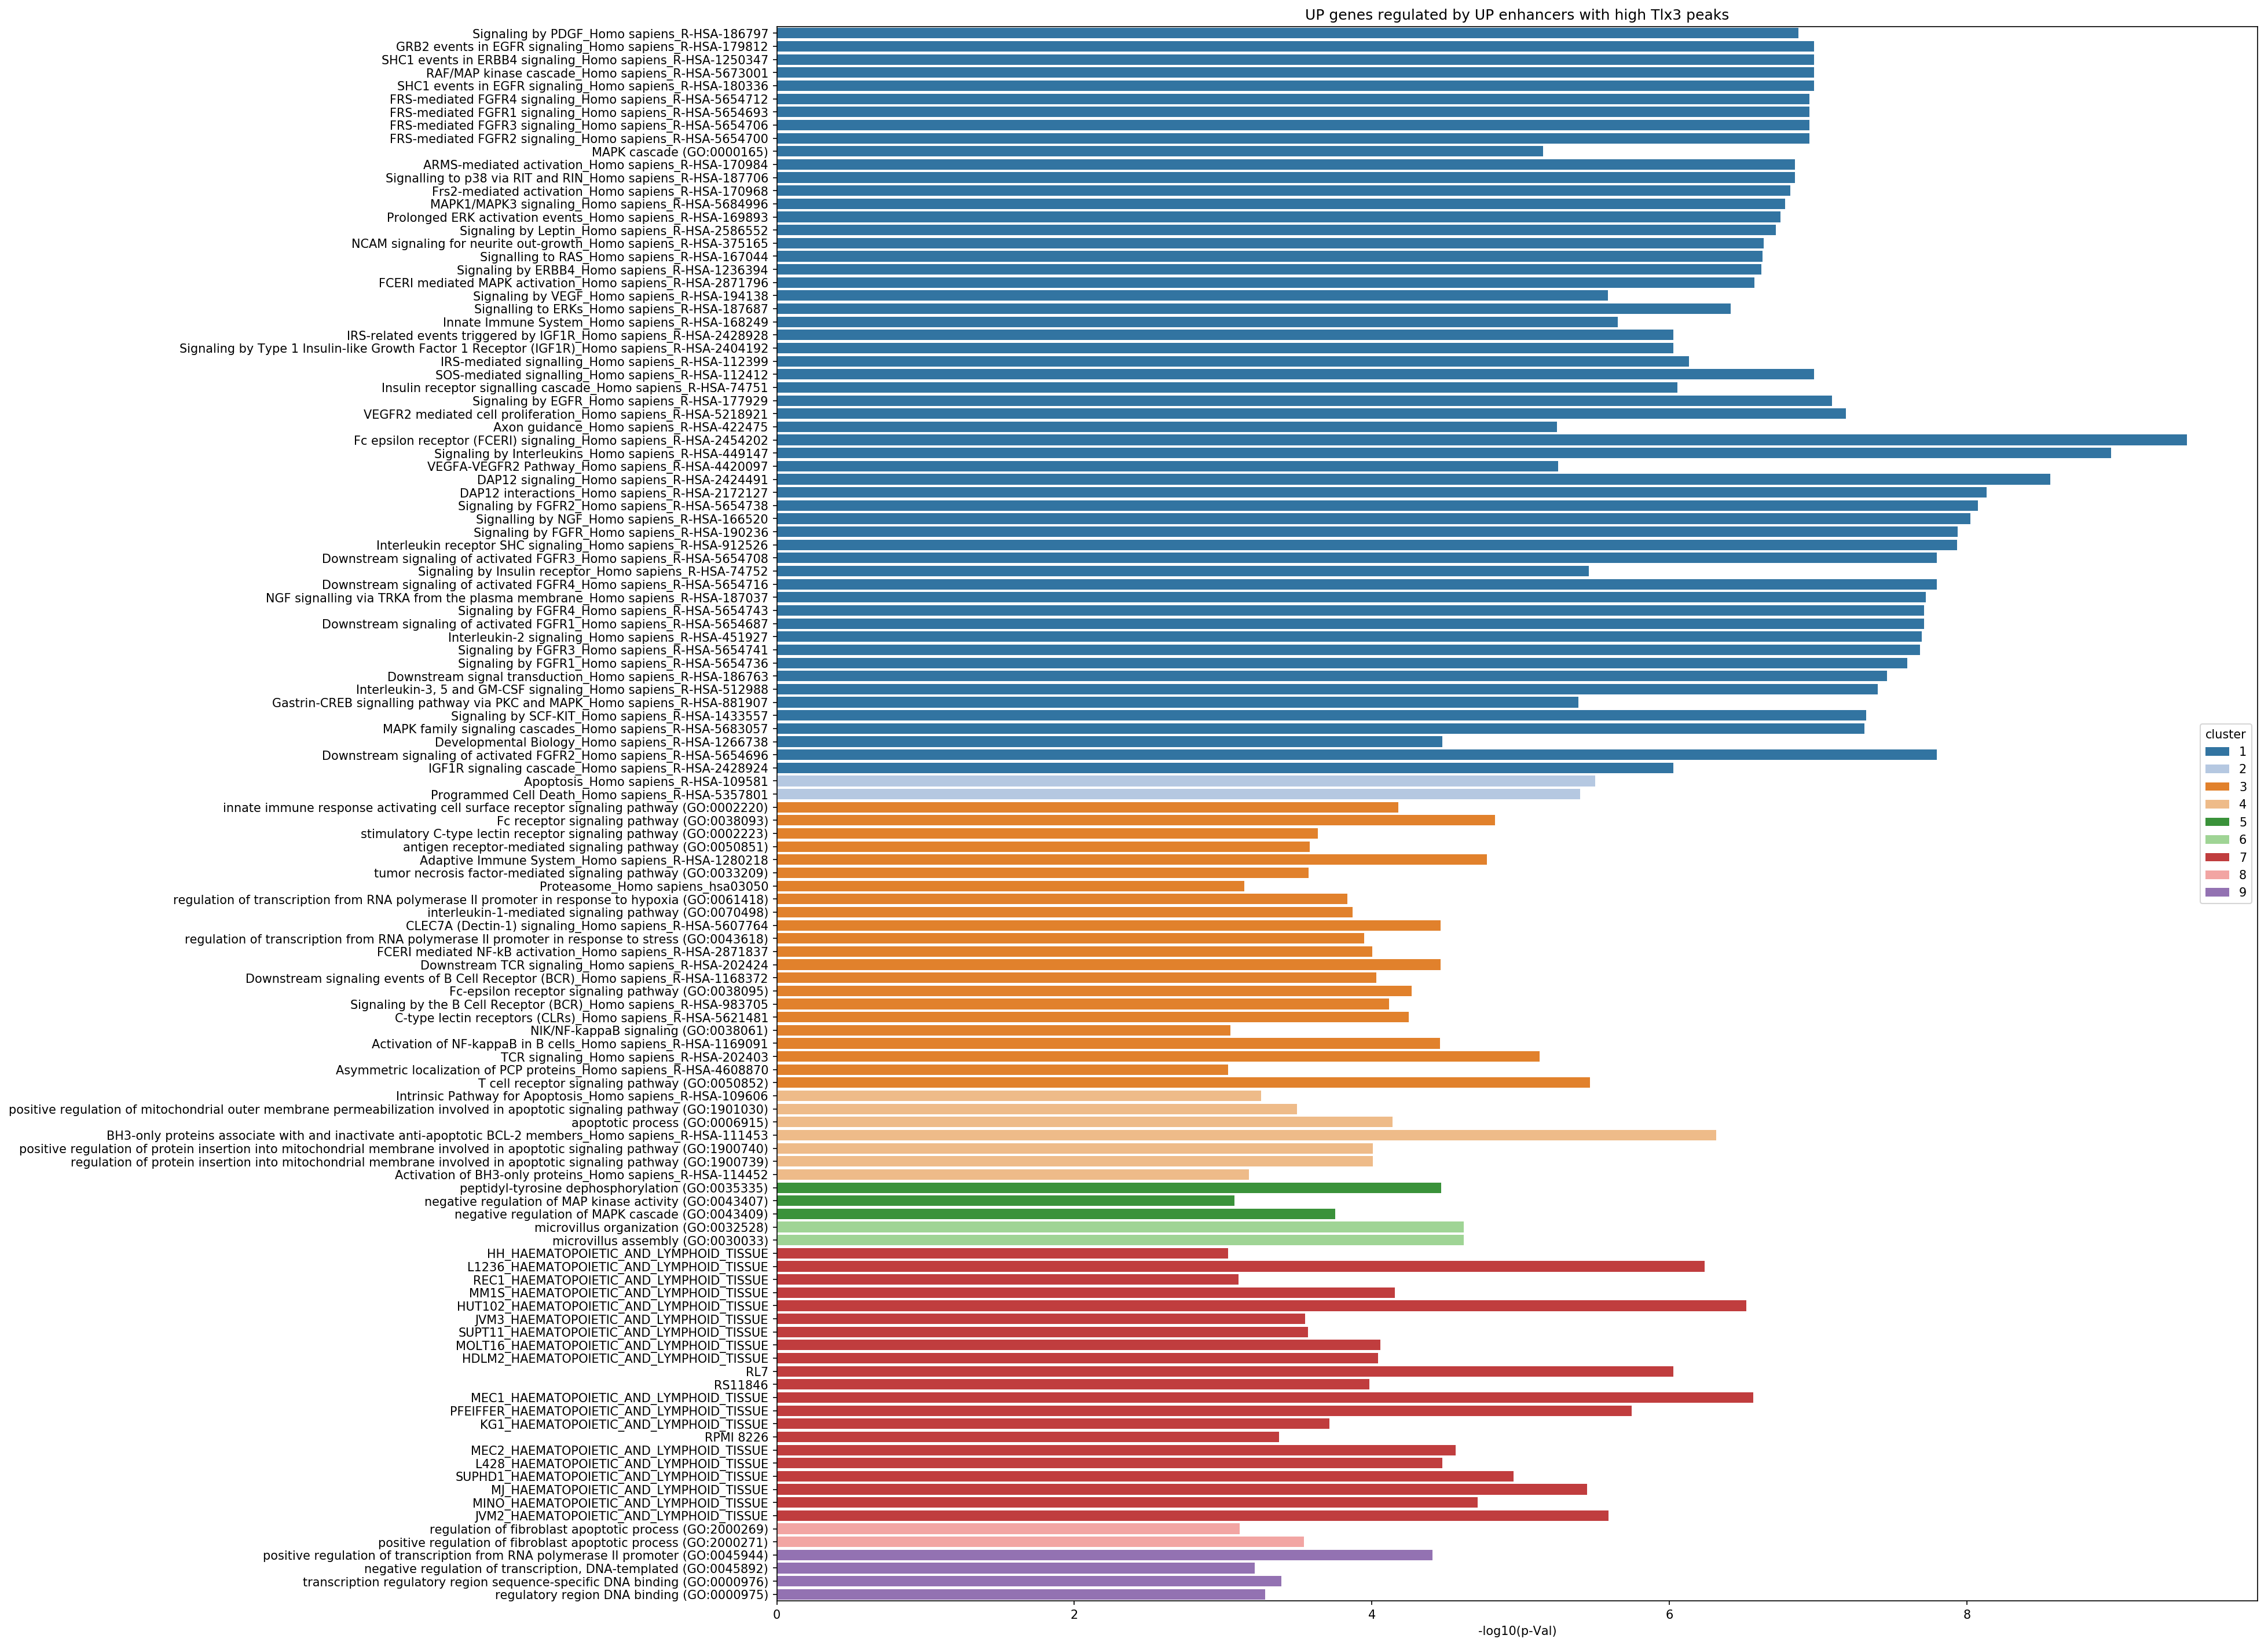

In [25]:
# --- Plot ---
# use consistent discrete palette
cm = 'tab20'

ds = enr_a.head(120)

f, ax = plt.subplots(figsize=(22, 24))
sns.barplot(y=ds.index,
            x='-log10(p-Val)',
            ax = ax, 
            hue ='cluster',
            dodge=False,
            data = ds,
            palette = cm)
ax.set_title('UP genes regulated by UP enhancers with high Tlx3 peaks')



## Calculate independent distance on selected gene sets (terms)

In [26]:
# Calculate independent distance on selected gene sets (terms)
enr_a = erl.cluster_jacc(enr_a)


## Double clustering: close terms in both categories

In [27]:
enr_grp = enr_a.groupby(by=['cluster','cluster_jacc'],axis=0)

# Fucntion takes double cluster and return common genes  

def get_cluster(cl, enr_grp):
    enr_clust = enr_a.loc[enr_grp.groups[cl]]
    gn_clust = set(enr_clust.iloc[0]['genes'])
    for i in range(len(enr_clust)):
        gn_clust = gn_clust & set(enr_clust.iloc[i]['genes'])
    
    return gn_clust

In [28]:
# Print clustes and common genes 


# Terms in cluster
for k in enr_grp.groups.keys():
    print(k)
    for i in list(enr_grp.groups[k]):
        print('\t',i)

#'num_terms :',len(list(enr_grp.groups[k]))


(6, 4)
	 microvillus organization (GO:0032528)
	 microvillus assembly (GO:0030033)
(5, 4)
	 peptidyl-tyrosine dephosphorylation (GO:0035335)
	 negative regulation of MAP kinase activity (GO:0043407)
	 negative regulation of MAPK cascade (GO:0043409)
(4, 4)
	 apoptotic process (GO:0006915)
	 BH3-only proteins associate with and inactivate anti-apoptotic BCL-2 members_Homo sapiens_R-HSA-111453
(11, 4)
	 regulation of endothelial cell proliferation (GO:0001936)
	 cellular response to growth factor stimulus (GO:0071363)
	 positive regulation of endothelial cell proliferation (GO:0001938)
	 positive regulation of transcription from RNA polymerase II promoter in response to stress (GO:0036003)
(10, 4)
	 regulation of interleukin-4 production (GO:0032673)
	 positive regulation of interleukin-4 production (GO:0032753)
(16, 4)
	 positive regulation of protein phosphorylation (GO:0001934)
	 regulation of cellular component organization (GO:0051128)
	 Rap1 signaling pathway_Homo sapiens_hsa04015


In [29]:
# Genes common in clusters 
for k in enr_grp.groups.keys():
    print(k, get_cluster(k, enr_grp))

(6, 4) {'RAP2A', 'RAPGEF6', 'RAPGEF2', 'FXYD5'}
(5, 4) {'PTPRJ', 'DUSP4', 'DUSP1', 'DUSP10', 'PTPN1'}
(4, 4) {'BBC3', 'PMAIP1', 'BID', 'BCL2L11', 'BCL2'}
(11, 4) {'VEGFA'}
(10, 4) {'CEBPB', 'PRKCQ', 'GATA3', 'CD28'}
(16, 4) {'RAP1A'}
(14, 4) {'BID', 'MALT1', 'MAP4K4'}
(13, 4) set()
(19, 4) {'RPS6KA5'}
(18, 4) {'CAMK2D', 'CAMK2B'}
(2, 1) {'PRKCQ', 'ARHGAP10', 'BCL2', 'PSMA6', 'PMAIP1', 'PSMB7', 'PSMA1', 'PSME4', 'BID', 'BBC3', 'GZMB', 'PSMD1', 'BCL2L11', 'STK24', 'VIM', 'GSN'}
(1, 6) {'IL2RB', 'RASA3', 'PSMA6', 'PSMB7', 'PSMA1', 'PSME4', 'CAMK2B', 'PSMD1', 'RAPGEF2', 'RASGRP4', 'CAMK2D', 'JAK2', 'GRB2', 'CALM1', 'KIT', 'IL5RA'}
(9, 4) {'KLF4', 'SMAD3', 'GATA3', 'MEF2A', 'ATF3'}
(4, 2) {'BBC3', 'PMAIP1', 'BID', 'BCL2L11', 'BCL2'}
(17, 4) {'GRB2', 'PIK3CG', 'JAK2'}
(3, 3) {'UBE2E2', 'TPP2', 'LCP2', 'PSMB7', 'CALM1', 'RNF19B', 'INPP5D', 'NR4A1', 'MALT1', 'ATG7', 'RAP1A', 'PSMA1', 'PTPRJ', 'SIGLEC5', 'GRB2', 'SAR1B', 'KIT', 'RAP1B', 'MAP3K8', 'CARD11', 'PHLPP1', 'PSME4', 'PDCD1LG2', 'REL', 

In [30]:
# Fucntion takes double cluster and return common genes in terms  

def get_cluster_terms(cl, enr_grp):
    enr_clust = enr_a.loc[enr_grp.groups[cl]]
    gn_clust = set(enr_clust.iloc[0]['term_genes'])
    for i in range(len(enr_clust)):
        gn_clust = gn_clust & set(enr_clust.iloc[i]['term_genes'])
    
    return gn_clust

In [31]:
#tm = enr_a.loc[enr_grp.groups[(7,4)]]

# Story TWO: Active in TLX3 only enhancers with mutation and active genes 

![title](im/Story21.png)

## Intersect mutation in TLX3 with active enhancers from privious analysis

In [32]:
## Up enhancers with up genes
# up_enh_up_genes -- list of enhancers
# --| enh_up_up= enh_df[enh_df['name'].isin(up_enh_up_genes)]
# --| enh_up_up_bd = pb.BedTool.from_dataframe(enh_up_up)

# enh_up_up_bd  --- bed file of enhancers
print('Up enhancers of up-regulated genes  = ',len(enh_up_up_bd))


# tlx_gn -- variants in TLX3


Up enhancers of up-regulated genes  =  2183


In [33]:
# Variant inside active enhancers

enh_mut_tlx = emm.bed_variants(tlx_gn,enh_up_up_bd)
print('Variants from TLX3 WGS in active enhacers = ', len(enh_mut_tlx))

Variants from TLX3 WGS in active enhacers =  691


In [34]:
# Save only if new analysis done
#~ enh_mut_tlx.saveas(join(WGS,'Ehn_Active_TLX3_mut.vcf'))

In [35]:
# Load table
import allel
enh_mut_tlx_tb = allel.vcf_to_dataframe(join(WGS,'Ehn_Active_TLX3_mut.vcf'),fields='*', numbers={'ALT': 4}, transformers=allel.ANNTransformer())

In [36]:
enh_mut_tlx_tb_fltr = enh_mut_tlx_tb[enh_mut_tlx_tb['FILTER_PASS']==True]

In [37]:
print('Variants from TLX3 WGS in active enhacers = ', len(enh_mut_tlx_tb))
print('Variants from TLX3 WGS in active enhacers PASS filter = ', len(enh_mut_tlx_tb_fltr))

Variants from TLX3 WGS in active enhacers =  691
Variants from TLX3 WGS in active enhacers PASS filter =  492


In [38]:
#enh_mut_tlx_tb[['FILTER_map','FILTER_PASS','FILTER_mrd20','FILTER_LowQual','FILTER_mrd10','FILTER_mrd30']].head(40)
#tnm = plt.hist(enh_mut_tlx_tb['REF'].apply(len), bins=40)
#tnm = plt.hist(enh_mut_tlx_tb['ALT_1'].apply(len), bins=40)

## Motifs around mutations in active enhancers

In [40]:
# Motifs models DB
db_f = '/home/sergio/tools/deepbind/db/db.tsv'

db = pd.read_csv(db_f, sep='\t',comment="#", index_col=0)
db = db[db['Labels'].isnull()]
db.drop(columns=['Class','Experiment Details','Model','Cite','Labels','Path','Comment'], inplace=True)

# Select on TFs in mouse
db_tf = db[db['Type']=='TF']
db_tf = db_tf[db_tf['Species']=='Mus musculus']


In [1]:
len(db_tf)

NameError: name 'db_tf' is not defined

In [41]:
# Reference genome fasta
from pyfaidx import Fasta
fn = '/home/sergio/media/NAS4/PFlab/TLX3_project/WES-seq/references/mouse_mm9_reference_genome.fa'
fa = Fasta(fn)

In [ ]:
# mut_tb = enh_mut_tlx_tb[['CHROM', 'POS', 'REF', 'ALT_1','is_snp']]
# mut_tb = mut_tb.assign(REF_Prot="",
#                        REF_score_ref = np.nan,
#                        REF_score_alt = np.nan,
#                        REF_model = "",
#                        ALT_Prot="", 
#                        ALT_score_ref = np.nan,
#                        ALT_score_alt = np.nan,
#                        ALT_model = "")
# cols = ['CHROM', 'POS', 'REF', 'ALT_1', 'is_snp', 
#         'REF_Prot', 'REF_model', 'REF_score_ref','REF_score_alt', 
#         'ALT_Prot', 'ALT_model', 'ALT_score_ref', 'ALT_score_alt']

# mut_tb = mut_tb[cols]

# pad = 10

# # Cycling
# for i in range(len(mut_tb)):
#     var= mut_tb.loc[i]

#     ln = len(var['REF'])
#     rg = fa[var['CHROM']][int(var['POS'])-pad:int(var['POS'])+ln+pad]

#     pos = var['POS'] - rg.start
#     ref = var['REF'].upper()
#     alt = var['ALT_1'].upper()

#     fs = rg.seq.upper()
#     fm = emm.mut(fs,pos,ref,alt)

#     ### Find best model
#     dv = db_tf.copy()

#     dv['score_ref'] = list(emm.deepbind_list(list(dv.index),fs)['score'])
#     dv['score_alt'] = list(emm.deepbind_list(list(dv.index),fm)['score'])
#     dv_r = dv.sort_values('score_ref',axis=0, ascending=False)
#     dv_a = dv.sort_values('score_alt',axis=0, ascending=False)



#     mut_tb['REF_Prot'].loc[i] = dv_r.iloc[0]['Protein']
#     mut_tb['REF_score_ref'].loc[i] = dv_r.iloc[0]['score_ref']
#     mut_tb['REF_score_alt'].loc[i] = dv_r.iloc[0]['score_alt'] 
#     mut_tb['REF_model'].loc[i] = dv_r.index[0] 


#     mut_tb['ALT_Prot'].loc[i] = dv_a.iloc[0]['Protein'] 
#     mut_tb['ALT_score_ref'].loc[i] = dv_a.iloc[0]['score_ref']
#     mut_tb['ALT_score_alt'].loc[i] = dv_a.iloc[0]['score_alt']
#     mut_tb['ALT_model'].loc[i] = dv_a.index[0] 


# mut_tb.to_csv(join(WGS,'Variants_Enhancers_Motifs_scores.csv'))

In [42]:
mut_tb = pd.DataFrame.from_csv(join(WGS,'Variants_Enhancers_Motifs_scores.csv'))


### Select motifs with high score and ones which change TFBS
#### Sort selected motifs by score changes caused by mutation

In [44]:
mut_tb_fltr = mut_tb[(mut_tb['REF_Prot'] != mut_tb['ALT_Prot']) & (mut_tb['REF_score_ref']>2)]
mut_tb_fltr['REF_score_diff'] = mut_tb_fltr['REF_score_ref'] - mut_tb_fltr['REF_score_alt']

mut_tb_fltr_srt = mut_tb_fltr.sort_values('REF_score_diff',axis=0, ascending=False)

In [46]:
mut_tb_fltr_srt.head(20)

,CHROM,POS,REF,ALT_1,is_snp,REF_Prot,REF_model,REF_score_ref,REF_score_alt,ALT_Prot,ALT_model,ALT_score_ref,ALT_score_alt,REF_score_diff
39,chr1,130663279,G,A,True,Znf740,D00083.001,15.219107,4.023426,Zfp202,D00047.001,6.921366,5.359330,11.195681
603,chr7,110957714,T,C,True,Tbx20,D00042.001,11.244208,0.088473,Tbx2,D00041.001,5.827298,2.770916,11.155735
105,chr12,77628836,C,T,True,Tbx3,D00018.001,9.698068,-0.657264,Snai1,D00075.001,0.910837,2.743205,10.355332
636,chr8,109157015,G,T,True,Sox6,D00039.001,12.976602,3.027496,Foxc2,D00061.001,4.857574,4.908360,9.949106
608,chr7,110957945,T,A,True,Sox6,D00039.001,9.504978,0.122871,Foxc2,D00061.001,0.762604,2.752552,9.382107
659,chr9,61516311,C,T,True,Tcf3,D00019.001,9.752139,0.690053,Rorb,D00036.001,3.834872,3.922790,9.062086
329,chr17,36371855,G,A,True,Nr5a2,D00069.001,7.183563,0.069277,Nr2e1,D00067.001,1.296328,3.370952,7.114286
145,chr13,56304582,C,T,True,Tbx4,D00043.001,8.725288,1.857753,Tbx2,D00041.001,5.001450,1.940268,6.867535
311,chr17,35477766,G,C,True,Snai1,D00075.001,5.993284,0.044310,Foxp2,D00009.001,0.043056,1.723904,5.948974
161,chr13,96757015,G,A,True,Tbx3,D00018.001,5.656111,-0.127555,Sox6,D00039.001,0.472988,3.958812,5.783666


## Find enhacers with TFS changes and associated genes

In [54]:
# Back to bed and enhancers list
mut_bd = mut_tb_fltr_srt[mut_tb_fltr_srt['REF_score_diff']>1][['CHROM','POS','REF','REF_Prot']]


mut_bd['POS_end'] = mut_bd['POS']+mut_bd['REF'].apply(len)
mut_bd = mut_bd[['CHROM','POS','POS_end', 'REF_Prot']]

mut_tf = pb.BedTool.from_dataframe(mut_bd).sort()
mut_tf_enh = enh.intersect(mut_tf,wb=True).to_dataframe()
mut_tf_enh.drop(columns=['score','strand','thickStart'], inplace=True)
mut_tf_enh.rename(columns={'thickEnd':'protein'}, inplace=True)

genes_mut_tf_enh = emm.gene_enh(list(mut_tf_enh['name']),enh2gn)

In [95]:
print('Genes with enhacers with TFBS cahnges = ', len(genes_mut_tf_enh)) 

Genes with enhacers with TFBS cahnges =  118


In [99]:
print('Genes with enhacers with TFBS cahnges:\n', genes_mut_tf_enh) 

Genes with enhacers with TFBS cahnges:
 ['VGLL4', 'AZIN1', 'LTA', 'ANTXR2', 'TBC1D5', 'FAM71B', '9230109A22RIK', 'NOVA1', 'SLC7A1', 'CYP51', 'PPCDC', 'CHD7', 'CDH1', 'SLC35B3', 'OLFM3', 'SLC25A19', 'AFF3', 'TLE3', 'DCUN1D4', 'CCND3', 'DAZL', 'LY6C2', 'CERK', 'CLVS1', 'GRAMD4', 'POU2AF1', 'SOAT2', 'GABRB3', 'PTPN1', 'PCNX', 'SIPA1L1', 'BC049715', 'RPP21', 'EEF1E1', 'TRPM1', 'OLFR517', 'H2-Q2', 'TIFAB', 'LRRC66', 'IKZF1', 'OLFR513', 'BYSL', 'GK2', 'LONRF2', 'HBB-Y', 'ATP10A', 'CXCR4', 'WISP1', 'UBE3A', 'TLN2', 'BASP1', 'GLRX', 'CD5', 'ATG7', 'RHOBTB3', 'RFTN1', 'PPP1R36', 'NR4A1', 'GRASP', 'CCNB2', 'CYP11A1', 'FAM49A', 'GRB2', 'ZSWIM6', 'UBL3', 'RDH10', 'CDKN1A', 'FTH1', 'PRICKLE1', 'PLCL2', 'SLC24A1', 'SMAD3', 'KLF13', 'ESRP1', 'STAU2', 'DENND4A', 'AVEN', 'GM9897', 'GM684', 'CCDC33', 'RPLP1', 'NEUROG1', 'SLA', 'KIF6', 'OLFR66', 'LY6G', 'PIM1', 'CEBPB', 'HBB-B2', 'BRE', 'H2-T3', 'KLF10', 'WBP11', 'RPL36-PS3', 'MYO1E', 'S1PR1', 'TPM1', 'RYR3', 'DPY19L4', '1700017B05RIK', 'SV2C', 'FIGNL1',

### Genes enrichments

In [82]:
genes_mut_tf_enh = [x.upper() for x in genes_mut_tf_enh]

enr_genes_mut_tf_enh = erl.enrich_gs(genes_mut_tf_enh,gss, path_lib='../data/EnrichrLibs')

GO_Biological_Process_2018 777
GO_Cellular_Component_2018 101
GO_Molecular_Function_2018 204
KEGG_2016 111
Reactome_2016 396
Cancer_Cell_Line_Encyclopedia 452
NCI-60_Cancer_Cell_Lines 75


In [83]:
# For futher analysis it is convinient to filter terms by p-value
enr_genes_mut_tf_enh = enr_genes_mut_tf_enh[enr_genes_mut_tf_enh['p-Val']<0.001]

## Cluster: this calculate and add cluster number column
enr_genes_mut_tf_enh = erl.cluster(genes_mut_tf_enh,enr_genes_mut_tf_enh)

# Make additional calculation on existing columns for visualization
enr_genes_mut_tf_enh.loc[:,'ass_genes_percnt'] = 100*enr_genes_mut_tf_enh.loc[:,'num_list']/enr_genes_mut_tf_enh.loc[:,'num_term']
enr_genes_mut_tf_enh.sort_values('cluster', axis=0, inplace = True)


In [96]:
#enr_genes_mut_tf_enh

Text(0.5,1,'Genes for UP enhancers with TF mutations')

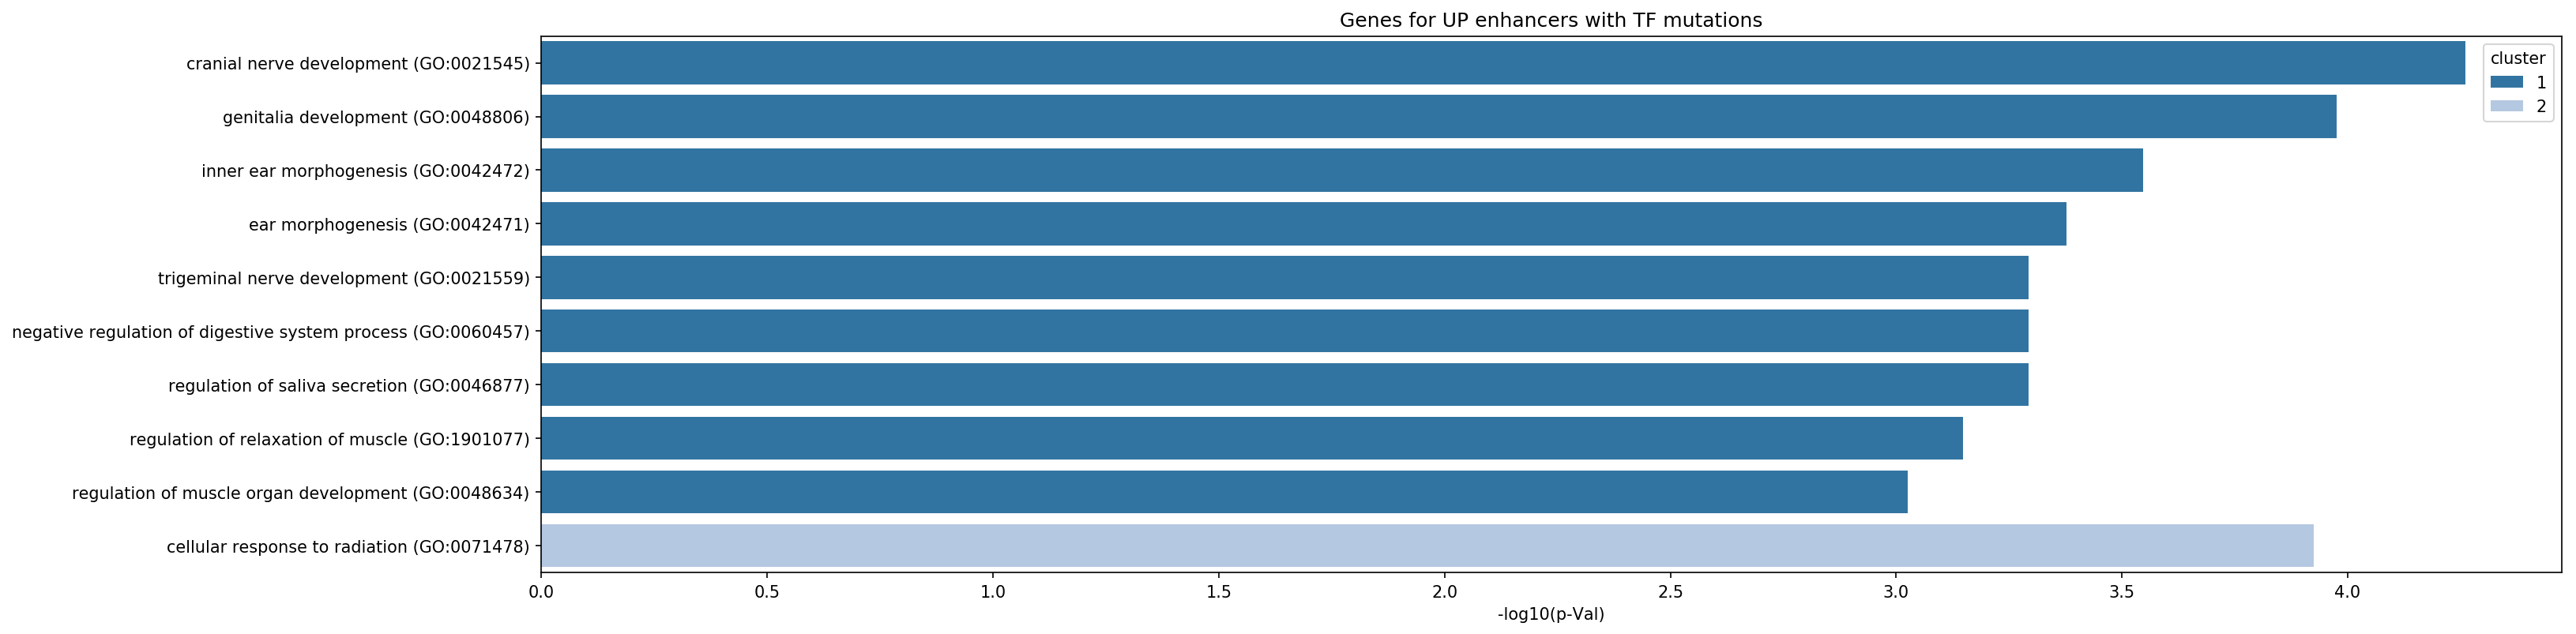

In [89]:
# --- Plot ---
# use consistent discrete palette
cm = 'tab20'

ds = enr_genes_mut_tf_enh.head(10)

f, ax = plt.subplots(figsize=(22, 6))
sns.barplot(y=ds.index,
            x='-log10(p-Val)',
            ax = ax, 
            hue ='cluster',
            dodge=False,
            data = ds,
            palette = cm)
ax.set_title('Genes for UP enhancers with TF mutations')

